<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice MLR using the Sacramento Real Estate Data

_Authors: Joseph Nelson (DC), Matt Brems (DC)_

---

We return to the Sacramento real estate data, but this time around we will be constructing multiple linear regression models. 

You will review the assumptions of multiple linear regression and practice building a model using the statsmodels package.

### 1. Load the data. 

In [119]:
import pandas as pd
shd_csv = './datasets/sacramento_real_estate_transactions_Clean.csv'
shd = pd.read_csv(shd_csv)
shd.head()

,Unnamed: 0,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [120]:
shd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 13 columns):
Unnamed: 0    984 non-null int64
street        984 non-null object
city          984 non-null object
zip           984 non-null int64
state         984 non-null object
beds          984 non-null int64
baths         984 non-null int64
sq__ft        984 non-null int64
type          984 non-null object
sale_date     984 non-null object
price         984 non-null int64
latitude      984 non-null float64
longitude     984 non-null float64
dtypes: float64(2), int64(6), object(5)
memory usage: 100.0+ KB


In [121]:
shd.describe()

,Unnamed: 0,zip,beds,baths,sq__ft,price,latitude,longitude
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,491.785569,95750.611789,2.913618,1.777439,1315.253049,234167.841463,38.607670,-121.355832
std,284.554324,85.176913,1.307175,0.895484,853.416702,138434.220875,0.145494,0.138268
min,0.000000,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,245.750000,95660.000000,2.000000,1.000000,951.500000,145000.000000,38.482714,-121.446121
50%,491.500000,95762.000000,3.000000,2.000000,1304.000000,214375.000000,38.626257,-121.376009
75%,738.250000,95828.000000,4.000000,2.000000,1718.500000,300000.000000,38.695611,-121.295557
max,984.000000,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


## Dummy Variables

---

It is important to be cautious with categorical variables, those that represent distict groups or categories, when building a regression. If put in a regression "as-is", categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.

### 2. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [122]:
'''Evaluating the different types of residence'''
shd['type'].value_counts()

Residential     917
Condo            53
Multi-Family     13
Unkown            1
Name: type, dtype: int64

In [123]:
'''Using the Pandas Get Dummies functionality to create dummy variables for the Type Column'''
shd_new = pd.get_dummies(shd, columns=['type'])

In [124]:
shd_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 16 columns):
Unnamed: 0           984 non-null int64
street               984 non-null object
city                 984 non-null object
zip                  984 non-null int64
state                984 non-null object
beds                 984 non-null int64
baths                984 non-null int64
sq__ft               984 non-null int64
sale_date            984 non-null object
price                984 non-null int64
latitude             984 non-null float64
longitude            984 non-null float64
type_Condo           984 non-null uint8
type_Multi-Family    984 non-null uint8
type_Residential     984 non-null uint8
type_Unkown          984 non-null uint8
dtypes: float64(2), int64(6), object(4), uint8(4)
memory usage: 96.2+ KB


In [125]:
'''Extracting out the apartments that have a SQ_FT of greater than 0. SQ_FT less than 0 does not make a lot of sense'''
shd_new = shd_new.loc[shd_new['sq__ft'] > 0,:] 

---

### A caution with dummy-coding

Let's touch on a caution moving forward and interpreting these.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> Scenario 1: Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occured in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to* is often referred to as the **reference category**.

### 3. Remove "Unkown" from your dummy coded variable dataframe and append the rest to the original data.

In [126]:
del shd_new['type_Unkown']

In [127]:
shd_new.head()

,Unnamed: 0,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type_Condo,type_Multi-Family,type_Residential
0,0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,1
1,1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,1
2,2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,1
3,3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,1
4,4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,1


### 4. Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three variables.* At least one of which should be a dummy-coded variable (either one we created before or a new one).

You may use either `sklearn` or `statsmodels` to do this.

In [128]:
'''Machine learning using sklearn'''
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

lm = linear_model.LinearRegression()
X = shd_new[['beds', 'sq__ft', 'baths', 'type_Residential']]
y = shd_new['price']

model = lm.fit(X,y)

print('R Square:' , model.score(X,y))

R Square: 0.491474716742


### 5. Plot the residuals against the true points to evaluate your MLR visually.

> **Tip:** with seaborn's `sns.lmplot` you can set `x`, `y`, and even a `hue` (which will plot regression lines by category in different colors) to easily plot a regression line.

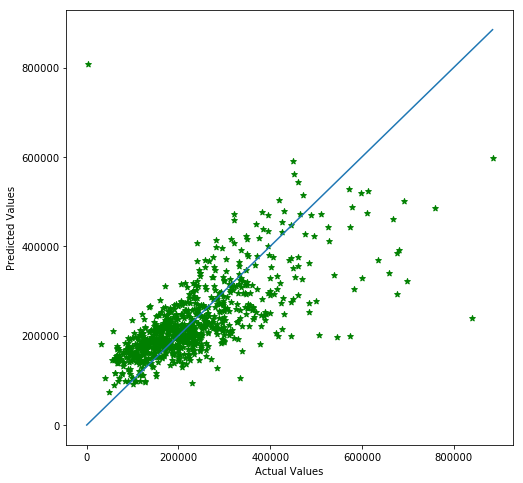

In [132]:
predictions = model.predict(X)

plt.figure(figsize=(8,8))
plt.scatter(y, predictions, marker='*', c='g')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0,np.max(y)],[0,np.max(y)])
plt.show()

### 6. List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

1. Linearity 
2. Independence 
3. Normality
4. Equality of Variance 
5. Independence of Predictors

All except the last one (Independence of Predictors) pertain to Multiple linear regression model

### 7. Pick at least two assumptions and articulate whether or not you believe them to be met  for your model and why.

1. Square feet had an impact on the model and rightfully so. The larger the square feet higher the price of the house 
2. For some reason I expected, the number of beds, baths to also have an impact on the price of the house, however based on doing an EDA between the price and the beds/bath, we did not see any kind of linear relation. Hence when we included these variables into the model, we did not see much of a difference 

### 8. Explain what the intercept in your model means in the context of your predictor variables.

In [133]:
# A:
print ('Coef:', model.coef_)
print('Intercept: ', model.intercept_)

Coef: [-15404.46388821    131.41415433   7432.22443426  40574.08097965]
Intercept:  17835.5559287


### 9. Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` function.

In [158]:
# A:
import statsmodels.api as sm 
X = shd_new[['sq__ft', 'beds', 'baths', 'type_Residential']].values
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
Y = shd_new['price']

print (X.shape, y.shape)

model = sm.OLS(Y,X)
model = model.fit()
predictions = model.predict()
model.summary()


(813, 5) (813,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     195.2
Date:                Tue, 17 Oct 2017   Prob (F-statistic):          4.47e-117
Time:                        00:11:47   Log-Likelihood:                -10386.
No. Observations:                 813   AIC:                         2.078e+04
Df Residuals:                     808   BIC:                         2.080e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           131.4142      7.274     18.067      0.000     117.136     145.692
x2          -1.54e+04   5287.156     -2.914      0.004   -2.58e+04   -5026.282
x3          7432.2244   6892.292      1.078      0.281   -6096.685     2.1e+04
x4          4.057e+04   1.25e+04      3.249      0.001    1.61e+04    6.51e+04
const       1.784e+04   1.54e+04      1.161      0.246   -1.23e+04     4.8e+04
==============================================================================
Omnibus:                      214.838   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6881.414
Skew:                           0.490   Prob(JB):                         0.00
Kurtosis:                      17.219   Cond. No.                     1.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 10. [Bonus] Summarize your findings.

You work for a real estate agency. You are asked to prepare an executive summary for your very busy boss highlighting the most important findings from your MLR model. Convey these findings in no more than two paragraphs. Be sure to briefly address any potential shortcomings of your model.


In [156]:
# A: 